In [2]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

from sktime.datasets import load_UCR_UEA_dataset

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # if gpu is available use gpu
device

device(type='cuda')

In [4]:
DATASET = 'ECG5000'

In [5]:
print(f'Loading the dataset: {DATASET} - split = train')

X_train, y_train = load_UCR_UEA_dataset(name=DATASET, split='train')
y_train = np.array(y_train, dtype=np.int32) # Since the features from the sktime are instatiated as objects we have to manually convert them

print(f'Number of instances in the dataset: {X_train.shape[0]}')
print(f'X train dimensions: {X_train.shape}')
print(f'y train dimensions: {y_train.shape}')

Loading the dataset: ECG5000 - split = train
Number of instances in the dataset: 500
X train dimensions: (500, 1)
y train dimensions: (500,)


In [6]:
print(f'Loading the dataset: {DATASET} - split = test')

X_test, y_test = load_UCR_UEA_dataset(name=DATASET, split='test')
y_test = np.array(y_test, dtype='int32') # Fixing the labels type

print(f'Number of instances in the dataset: {X_test.shape[0]}')
print(f'X test dimensions: {X_test.shape}')
print(f'y test dimensions: {y_test.shape}')

Loading the dataset: ECG5000 - split = test
Number of instances in the dataset: 4500
X test dimensions: (4500, 1)
y test dimensions: (4500,)


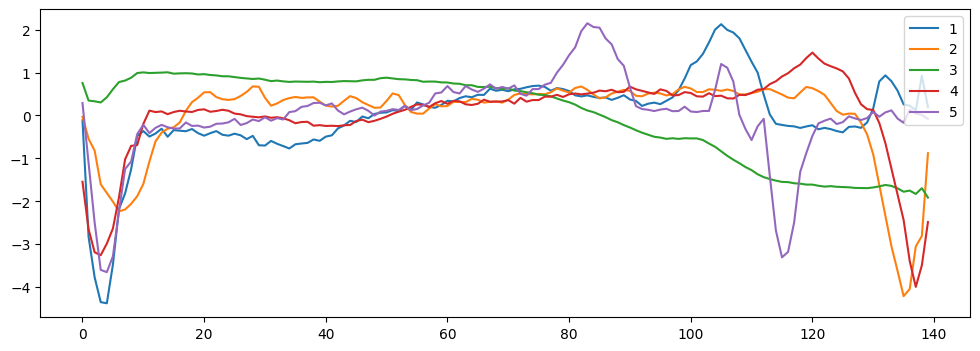

In [7]:
series_length = X_train.values[y_train.argmax()][0].shape[0]

plt.figure(figsize=(12, 4))
plt.plot(list(range(0, series_length, 1)), X_train.values[(y_train == 1).argmax()][0].tolist(), label='1')
plt.plot(list(range(0, series_length, 1)), X_train.values[(y_train == 2).argmax()][0].tolist(), label='2')
plt.plot(list(range(0, series_length, 1)), X_train.values[(y_train == 3).argmax()][0].tolist(), label='3')
plt.plot(list(range(0, series_length, 1)), X_train.values[(y_train == 4).argmax()][0].tolist(), label='4')
plt.plot(list(range(0, series_length, 1)), X_train.values[(y_train == 5).argmax()][0].tolist(), label='5')
plt.legend(loc='upper right')
plt.show()

In [8]:
print('Separating only positive instances...')
old_number_of_instances = X_train.shape[0]

X_train = X_train[y_train == 1]
y_train = y_train[y_train == 1]

print(f'A number of {X_train.shape[0]} will be used for training phase.')
print(f'{old_number_of_instances - X_train.shape[0]} instances will be discarted as negative samples.')

Separating only positive instances...
A number of 292 will be used for training phase.
208 instances will be discarted as negative samples.


In [9]:
X_train_transformed = []

for val in X_train.values:
    X_train_transformed.append(val[0].tolist())

X_train_transformed = np.array(X_train_transformed)
X_train_transformed.shape

(292, 140)

In [10]:
X_test_transformed = []

for val in X_test.values:
    X_test_transformed.append(val[0].tolist())

X_test_transformed = np.array(X_test_transformed)
X_test_transformed.shape

(4500, 140)

In [11]:
y_test_transformed = []

for val in y_test:
    y_test_transformed.append(val if val == 1 else -1)

y_test_transformed = np.array(y_test_transformed)

print(y_test_transformed.shape)
print(np.unique(y_test_transformed, return_counts=True))

(4500,)
(array([-1,  1]), array([1873, 2627], dtype=int64))


In [12]:
class Encoder(nn.Module):

    def __init__(self, sequence_length: int, n_features: int, embedding_dim: int) -> None:
        super().__init__()

        self.sequence_length = sequence_length
        self.n_features = n_features
        
        self.embedding_dim = embedding_dim
        self.hidden_dim = 2 * embedding_dim

        self.rnn1 = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True,
        )

        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )

    def forward(self, x):
        x = x.reshape((1, self.sequence_length, self.n_features)) # Batch_Size, Sequence Length, Number of Features
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)

        return hidden_n.reshape((self.n_features, self.embedding_dim))

In [13]:
class Decoder(nn.Module):

    def __init__(self, sequence_length: int, input_dim: int, n_features: int):
        super().__init__()

        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.hidden_dim = 2 * input_dim
        self.n_features = n_features

        self.rnn1 = nn.LSTM(
            input_size=input_dim,
            hidden_size=input_dim,
            num_layers=1,
            batch_first=True
        )

        self.rnn2 = nn.LSTM(
            input_size=input_dim,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(self.sequence_length, self.n_features)
        x = x.reshape((self.n_features, self.sequence_length, self.input_dim))

        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.sequence_length, self.hidden_dim))

        return self.output_layer(x)

In [14]:
class RAE(nn.Module):

    def __init__(self, sequence_length, n_features, embedding_dim):
        super().__init__()

        self.encoder = Encoder(sequence_length, n_features, embedding_dim).to(device)
        self.decoder = Decoder(sequence_length, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [15]:
from torch.utils.data import Dataset
from typing import Tuple

class CustomDataset(Dataset):

    def __init__(self, X: np.ndarray, y: np.ndarray = None) -> None:
        self.X = X
        if y is not None:
            self.y = y

        assert len(X) == len(y)

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        if self.y is not None:
            return (
                torch.from_numpy(self.X[idx]).unsqueeze(1).permute(1, 0).float(),
                torch.from_numpy(np.array([self.y[idx]])).float()
            )

        return (
            torch.from_numpy(self.X[idx]).float(),
            None
        )

In [16]:
train_dataset = CustomDataset(X=X_train_transformed, y=y_train)

print(len(train_dataset))
print(train_dataset[0][0].shape, train_dataset[0][1].shape)

292
torch.Size([1, 140]) torch.Size([1])


In [17]:
test_dataset = CustomDataset(X=X_test_transformed, y=y_test_transformed)
print(len(test_dataset))
print(test_dataset[0][0].shape, test_dataset[0][1].shape)

4500
torch.Size([1, 140]) torch.Size([1])


In [18]:
model = RAE(series_length, 1, embedding_dim=128)
model.to(device)

RAE(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [19]:
def create_dataset(sequences):
    dataset = [torch.tensor(s).unsqueeze(1) for s in sequences] # converting each sequence to a tensor & adding a dimension
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

In [20]:
train_dataset, seq_len, n_features = create_dataset(X_train_transformed)
val_dataset, seq_len, n_features = create_dataset(X_test_transformed)

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

history = dict(train=[], val=[])

for epoch in range(1, 151, 1):
    model = model.train()
    
    train_losses = []
    for x in train_dataset:
        x = x.float().to(device)
        optimizer.zero_grad()
        
        x_hat = model(x)

        loss = criterion(x_hat, x)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
        for x in val_dataset:
            x = x.float().to(device)
            x_hat = model(x)

            loss = criterion(x_hat, x)

            val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    print(f'Epoch {epoch} - Train Loss = {train_loss}, Val Loss = {val_loss}')

Epoch 1 - Train Loss = 0.5055478254001434, Val Loss = 0.5640211169372003
Epoch 2 - Train Loss = 0.3657241741782182, Val Loss = 0.6010134977201621
Epoch 3 - Train Loss = 0.3602459561845211, Val Loss = 0.5363100304603576
Epoch 4 - Train Loss = 0.35866348093299016, Val Loss = 0.5456458760864205
Epoch 5 - Train Loss = 0.3377956544648703, Val Loss = 0.5535020292749008
Epoch 6 - Train Loss = 0.33208194632746585, Val Loss = 0.5232717054966424
Epoch 7 - Train Loss = 0.32412543790797665, Val Loss = 0.561449188793699
Epoch 8 - Train Loss = 0.3276621407688889, Val Loss = 0.5144499881300661
Epoch 9 - Train Loss = 0.3421687857337194, Val Loss = 0.5376774667153755
Epoch 10 - Train Loss = 0.3290771125522378, Val Loss = 0.5230306864182155
Epoch 11 - Train Loss = 0.3123311494821555, Val Loss = 0.5261522995779911
Epoch 12 - Train Loss = 0.3013195170421306, Val Loss = 0.5119774456040727
Epoch 13 - Train Loss = 0.29629079568875977, Val Loss = 0.4996448438813289
Epoch 14 - Train Loss = 0.3028261138457958, 

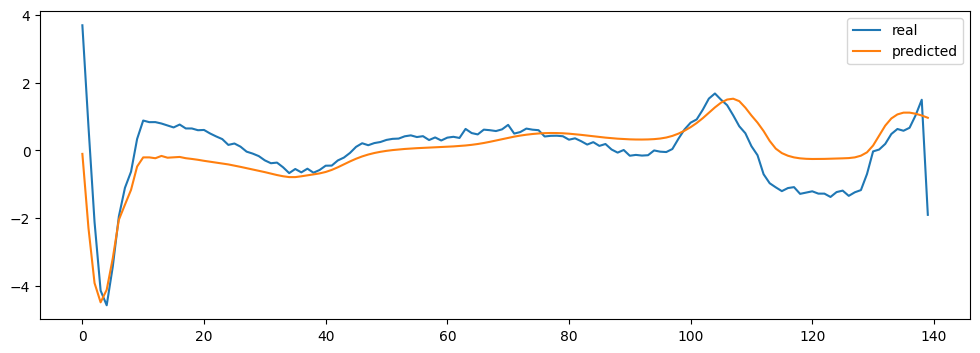

In [23]:
series_length = 140

plt.figure(figsize=(12, 4))
plt.plot(list(range(0, series_length, 1)), val_dataset[(y_test == 1).argmax()].reshape(140).tolist(), label='real')
plt.plot(list(range(0, series_length, 1)), model(train_dataset[0].float().to(device)).reshape(140).tolist(), label='predicted')
plt.legend(loc='upper right')
plt.show()

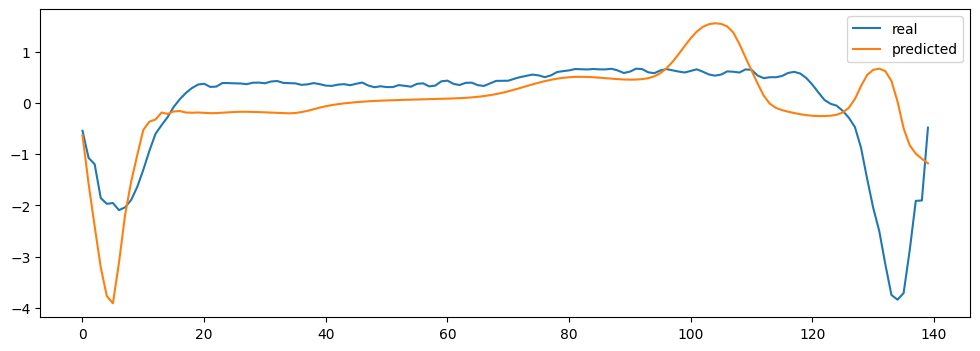

In [27]:
plt.figure(figsize=(12, 4))
plt.plot(list(range(0, series_length, 1)), val_dataset[(y_test == 2).argmax()].reshape(140).tolist(), label='real')
plt.plot(list(range(0, series_length, 1)), model(val_dataset[(y_test == 2).argmax()].float().to(device)).reshape(140).tolist(), label='predicted')
plt.legend(loc='upper right')
plt.show()

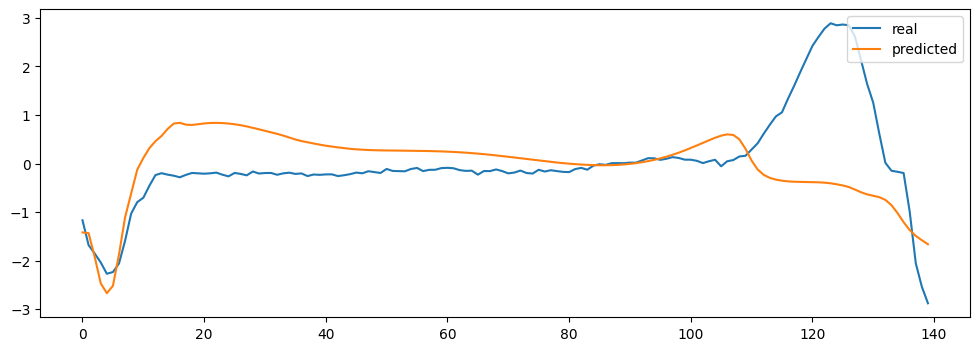

In [29]:
plt.figure(figsize=(12, 4))
plt.plot(list(range(0, series_length, 1)), val_dataset[(y_test == 3).argmax()].reshape(140).tolist(), label='real')
plt.plot(list(range(0, series_length, 1)), model(val_dataset[(y_test == 3).argmax()].float().to(device)).reshape(140).tolist(), label='predicted')
plt.legend(loc='upper right')
plt.show()

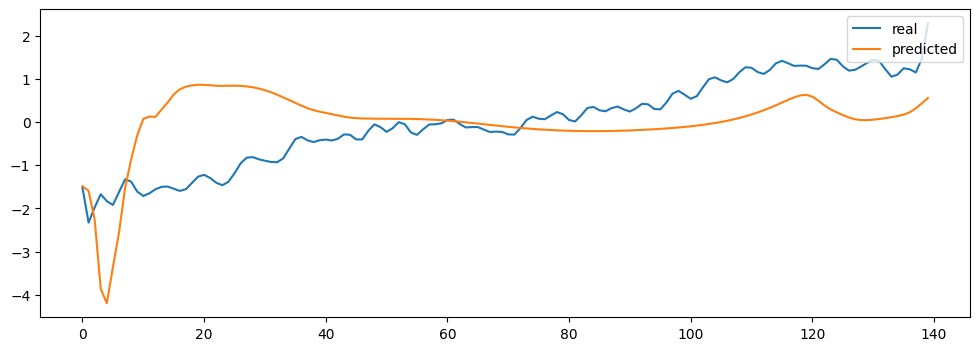

In [30]:
plt.figure(figsize=(12, 4))
plt.plot(list(range(0, series_length, 1)), val_dataset[(y_test == 4).argmax()].reshape(140).tolist(), label='real')
plt.plot(list(range(0, series_length, 1)), model(val_dataset[(y_test == 4).argmax()].float().to(device)).reshape(140).tolist(), label='predicted')
plt.legend(loc='upper right')
plt.show()

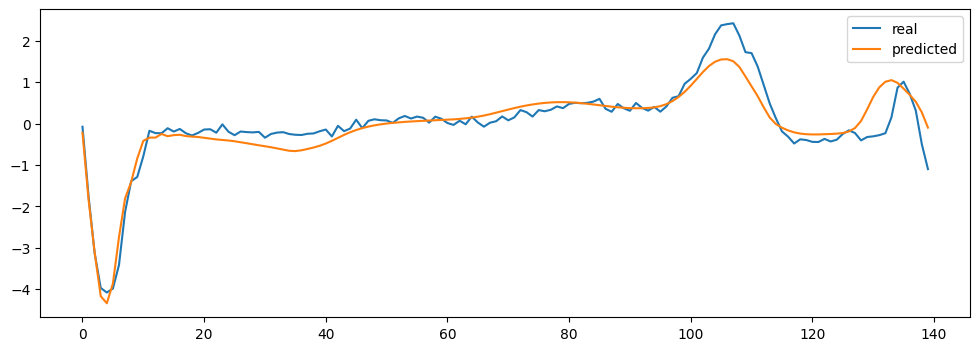

In [31]:
plt.figure(figsize=(12, 4))
plt.plot(list(range(0, series_length, 1)), val_dataset[(y_test == 5).argmax()].reshape(140).tolist(), label='real')
plt.plot(list(range(0, series_length, 1)), model(val_dataset[(y_test == 5).argmax()].float().to(device)).reshape(140).tolist(), label='predicted')
plt.legend(loc='upper right')
plt.show()

In [36]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.MSELoss().to(device)

    with torch.no_grad():
        model = model.eval()  

        for x in dataset:
            x = x.float().to(device)
            x_hat = model(x)

            loss = criterion(x_hat, x)  # calculating loss
            
            predictions.append(x_hat.cpu().numpy().flatten()) # appending predictions & loss to results

            losses.append(loss.item())

    return predictions, losses

<AxesSubplot: ylabel='Count'>

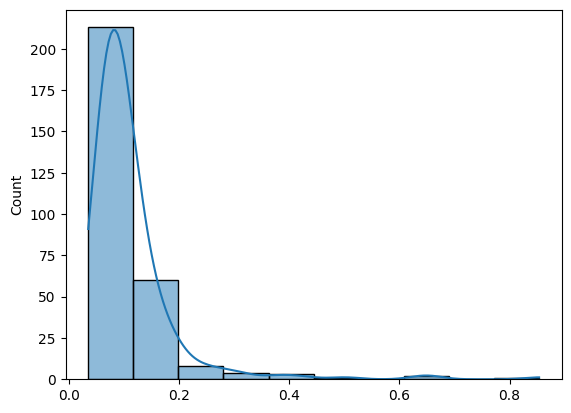

In [37]:
import seaborn as sns

_, losses = predict(model, train_dataset)
sns.histplot(losses, bins= 10, kde= True)

In [38]:
THRESHOLD = 0.15
predictions, prediction_losses = predict(model, val_dataset)
correct = sum(l <= THRESHOLD for l in prediction_losses)

print(f'Correct normal predictions: {correct} / {len(test_dataset)}')

Correct normal predictions: 2228 / 4500
